In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import pandas as pd
from pandas import DataFrame,Series
import matplotlib.pyplot as plt
import numpy as np

# Pandas私房手册-数据的聚合和分组计算（groupby）

学习`groupby`聚合技术，首先要在脑海里有一个概念，即：`groupby`聚合包含三个步骤：
1. 拆分（splitting）：根据一些标准将数据分成组。
2. 应用（applying）：将一个函数独立地应用于每个组。
3. 合并（combining）：将结果组合起来形成最终结果。

## 拆分（splitting）

首先来看`groupby`方法的`by`参数，它是进行拆分的依据，`by`可以是下面任何一种对象：
- 函数，传入的是行或者列的索引
- 与`axis`参数指定轴长度相同的列表或者`numpy`数组
- 一个字典或者Series，提供`label`->`group`的映射
- 一个字符串，表示`DataFrame`对象的列，当然`df.groupby('A')`仅仅就是`df.groupby(df['A'])`的语法糖
- 一个表示索`DataFrame`对象索引层级（index level）的字符串
- 上面任意项组成的列表

### 根据列名拆分

对于`DataFrame`对象，我们可以根据列名或者列名组成的列表进行`groupby`：

In [26]:
df = pd.DataFrame({
    'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
    'B': ['one', 'one', 'two', 'three', 'two', 'two', 'one', 'three'],
    'C': np.random.randn(8),
    'D': np.random.randn(8)
})
df
grouped1 = df.groupby('A')
grouped2 = df.groupby(['A', 'B'])
grouped2.mean()

,A,B,C,D
0,foo,one,0.633891,0.726946
1,bar,one,-1.097307,-0.729896
2,foo,two,0.462048,-1.158519
3,bar,three,2.480446,0.852052
4,foo,two,0.789076,0.621990
5,bar,two,0.055637,-1.212469
6,foo,one,-0.645030,1.136094
7,foo,three,1.570155,-1.620567


C         D
A   B                        
bar one   -1.097307 -0.729896
    three  2.480446  0.852052
    two    0.055637 -1.212469
foo one   -0.005569  0.931520
    three  1.570155 -1.620567
    two    0.625562 -0.268265

### 根据索引拆分

不管是单层索引还是多层索引，我们都可以通过`level`参数，指定索引的层级或者索引的名称根据索引来`groupby`：

In [35]:
df2 = df.set_index(['A', 'B'])
df2
# level=df2.index.names.difference(['B'])就相当于level='A'，这里主要是为了说明names的用法。
# 索引的名称df2.index.names是`FrozenList`类型，它有个`difference`方法，可以快速获得差集。
# level也可以是整数表示的层级，从0开始，从外向内，依次增加，这里就可以是level=0
grouped = df2.groupby(level=df2.index.names.difference(['B']))
grouped.sum()

C         D
A   B                        
foo one    0.633891  0.726946
bar one   -1.097307 -0.729896
foo two    0.462048 -1.158519
bar three  2.480446  0.852052
foo two    0.789076  0.621990
bar two    0.055637 -1.212469
foo one   -0.645030  1.136094
    three  1.570155 -1.620567

,C,D
A,,
bar,1.438776,-1.090313
foo,2.810140,-0.294057


当然，像`sum`这样的聚合函数本身就有`level`参数，因此我们有更简便的写法：

In [36]:
df2.sum(level=1)

,C,D
B,,
one,-1.108446,1.133144
two,1.306761,-1.748998
three,4.050601,-0.768515


0.20版本以后，如果索引有名称的话，我们甚至可以直接传入名称，而不用使用`level`参数：

In [37]:
df2.groupby('B').sum()

,C,D
B,,
one,-1.108446,1.133144
three,4.050601,-0.768515
two,1.306761,-1.748998


### 同时根据索引和列名拆分

甚至可以把索引和列名组成的列表传给`by`参数：

In [38]:
df3 = df2.reset_index('B')
df3.groupby(['A', 'B']).sum()

C         D
A   B                        
bar one   -1.097307 -0.729896
    three  2.480446  0.852052
    two    0.055637 -1.212469
foo one   -0.011139  1.863040
    three  1.570155 -1.620567
    two    1.251124 -0.536529

如果索引的名称和列名重名，可以使用`Grouper`对象，通过`level`参数指定索引，`Grouper`对象会后还会提到：

In [59]:
df3 = df2.rename_axis(index={'B':'C'})
df3 = df3.reset_index('A')
df3
df3.groupby(['A', pd.Grouper(level='C')]).sum()

,A,C,D
C,,,
one,foo,0.633891,0.726946
one,bar,-1.097307,-0.729896
two,foo,0.462048,-1.158519
three,bar,2.480446,0.852052
two,foo,0.789076,0.621990
two,bar,0.055637,-1.212469
one,foo,-0.645030,1.136094
three,foo,1.570155,-1.620567


C         D
A   C                        
bar one   -1.097307 -0.729896
    three  2.480446  0.852052
    two    0.055637 -1.212469
foo one   -0.011139  1.863040
    three  1.570155 -1.620567
    two    1.251124 -0.536529

### `by`参数是函数

`by`参数还可以是一个函数，但是我一开始把这个函数和`apply`的函数搞混了，所以半天没想清楚。函数传入的是行或者列的索引（`axis=0`或者`index`传入的是行索引，`axis=1`或者`columns`传入的是列的索引），每次传入一个索引值，返回一个值，这些值最终构成一个序列，这个序列的长度和选定的`axis`轴的长度要一致，序列中的值我把它称为标签，`axis`为0或者`index`，代表垂直方向，序列的长度为列的长度，每一行对应一个标签，`axis`为1或者`column`，代表水平方向，序列的长度为行的长度，每一列对应一个标签，最终根据标签进行分组，相同的标签分为一组。

如下面的例子，`axis=1`，传入水平方向的列索引，每次传入一个值，依次传入`A, B, C, D`，分别返回`vowel, consonant, consonant, consonant`，构成一个序列，分别对应四列，分成2组，`A`列为一组，标签为`vowel`，`B,C,D`列为一组，标签为`consonant`。

In [66]:
def get_letter_type(letter):
    if letter.lower() in 'aeiou':
        return 'vowel'
    else:
        return 'consonant'


grouped = df.groupby(get_letter_type, axis=1)
grouped.count()

,consonant,vowel
0,3,1
1,3,1
2,3,1
3,3,1
4,3,1
5,3,1
6,3,1
7,3,1


再如下面的例子，`axis=0`，沿着垂直方向传入行索引，每次传入一个值，依次传入0到7，分别返回`'a','a','a','a','b','b','b'`，分别对应8行，分为2组，前5行为一组，标签为`'a'`，后3列为一组，标签为`'b'`：

In [67]:
df.groupby(lambda x: 'a' if x < 5 else 'b').sum()

,C,D
a,3.268153,0.312573
b,0.980763,-1.696943


## 了解`GroupBy`组对象

`groupby`操作返回的结果是一个`GroupBy`对象，它相当于一个字典，包含每个组的标签和对应的组的数据，它除了可以像字典一样轮询以外，还有一些属性和方法方便对组进行操作：
- `groups`：返回一个字典，键是根据`by`参数计算得到的唯一的值，值是对应的组的轴标签
- `first()`：将所有组的第一个元素拼接起来，构成一个`dataframe`返回
- `last()`：将所有组的最后一个元素拼接起来，构成一个`dataframe`返回
- `get_group()`：根据组的键值获取组的内容

### `groups`属性

返回一个字典，键是根据`by`参数计算得到的唯一的值，值是对应的组的轴标签，通过`python`的`len`函数可以方便的知道一共分了多少组：

In [120]:
df = pd.DataFrame({
    'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
    'B': ['one', 'one', 'two', 'three', 'two', 'two', 'one', 'three'],
    'C': np.random.randn(8),
    'D': np.random.randn(8)
})
df.groupby('A').groups
gd = df.groupby(get_letter_type, axis=1).groups
gd
len(gd)

{'bar': Int64Index([1, 3, 5], dtype='int64'),
 'foo': Int64Index([0, 2, 4, 6, 7], dtype='int64')}

{'consonant': Index(['B', 'C', 'D'], dtype='object'),
 'vowel': Index(['A'], dtype='object')}

2

### `get_group()`方法

根据组的键值获取某个组：

In [146]:
df = pd.DataFrame({'X': ['B', 'B', 'A', 'A'], 'Y': [1, 3, 4, 2]})
df.groupby('X').get_group('A')

,X,Y
2,A,4
3,A,2


### `first()`，`last()`方法

将所有组的第一个或最后一个行或者列拼接起来，构成一个dataframe返回：

In [68]:
idx = [1, 2, 3, 1, 2, 3]
s = pd.Series([1, 2, 3, 10, 20, 30], index=idx)
s
grouped = s.groupby(level=0) # 或者s.groupby(s.index)
grouped.first()
grouped.last()
grouped.sum()

1     1
2     2
3     3
1    10
2    20
3    30
dtype: int64

1    1
2    2
3    3
dtype: int64

1    10
2    20
3    30
dtype: int64

1    11
2    22
3    33
dtype: int64

### `head()`，`tail()`方法

`first()`，`last()`针对单行，那么`head()`，`tail()`则可以自定义行数，如下：

In [27]:
idx = [1, 2, 3, 1, 2, 3]
s = pd.Series([1, 2, 3, 10, 20, 30], index=idx)
grouped = s.groupby(level=0) # 或者s.groupby(s.index)
grouped.head(1)
grouped.tail(1)

1    1
2    2
3    3
dtype: int64

1    10
2    20
3    30
dtype: int64

### `nth()`方法

如果想指定获取第几行，而不是头或者尾部，那么可以使用`nth()`方法，注意是从0开始计数：

In [73]:
df = pd.DataFrame(
    [[1, np.nan, np.nan], [1, 4, np.nan], [5, 6, 7], [5, 7, np.nan], [5, 4, 3]
     ],
    columns=['A', 'B', 'C'])
df

,A,B,C
0,1,NaN,NaN
1,1,4.0,NaN
2,5,6.0,7.0
3,5,7.0,NaN
4,5,4.0,3.0


In [70]:
df.groupby('A').nth(2)
df.groupby('A').nth(-1)

,B,C
A,,
5,4.0,3.0


,B,C
A,,
1,4.0,NaN
5,4.0,3.0


对于那些`nan`的值，你想跳过，那么可以设置`dropna`参数，对于多列，可以是`any`或者`all`，来指定是只要有`nan`就跳过还是所有的列为`nan`才跳过：

In [74]:
# 当dropna='any'时，1分类没有一个能满足条件，因此1分类为`NaN, NaN`
df.groupby('A').nth(1, dropna='any')

,B,C
A,,
1,NaN,NaN
5,4.0,3.0


可以传入列表，一次选择多行：

In [75]:
df.groupby('A').nth([0, 2])

,B,C
A,,
1,NaN,NaN
5,6.0,7.0
5,4.0,3.0


### `cumcount()`方法

如果要查看每一行在组里出现的顺序，可以使用`cumcount()`方法，通过`ascending`参数来控制升序还是降序：

In [137]:
dfg = pd.DataFrame(list('aaabba'), columns=['A'])
dfg

,A
0,a
1,a
2,a
3,b
4,b
5,a


In [138]:
dfg.groupby('A').cumcount()

0    0
1    1
2    2
3    0
4    1
5    3
dtype: int64

### `ngroup()`方法

0.20.2版本以后，可以通过`ngroup()`方法查看组的顺序，注意和`cumcount()`的区别，一个是组里的行，一个是组，同样也有`ascending`参数，个人觉得这个名字没有起好，和`nth()`相似，总让人误以为是想要获取第几个组：

In [139]:
dfg.groupby('A').ngroup()

0    0
1    0
2    0
3    1
4    1
5    0
dtype: int64

### 从组中获取列

创建`GroupBy`对象之后，可能需要对每一列执行不同的操作。因此，可以使用类似于从DataFrame获取列的方法`[]`：

In [25]:
df = pd.DataFrame({
    'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
    'B': ['one', 'one', 'two', 'three', 'two', 'two', 'one', 'three'],
    'C': np.random.randn(8),
    'D': np.random.randn(8)
})
grouped = df.groupby('A')
# 想要对C列分组求和，对D列分组求均值，可以这样做
# 当然更简单的方法是直接使用groupby对象的agg方法：grouped.agg({'C':'sum', 'D':'mean'})
grouped['C'].sum()
grouped['D'].mean()

A
bar    1.175763
foo    0.787515
Name: C, dtype: float64

A
bar    0.573376
foo   -0.751227
Name: D, dtype: float64

`df.groupby('A')['C']`相当于`df['C'].groupby(df['A'])`的语法糖。

### 历遍组对象

可以对`GroupBy`对象进行历遍，每次返回一个组的名称和组，如果`groupby`的时候，有多个`key`，则组的名称是一个元组：

In [26]:
grouped = df[:4].groupby(['A', 'B'])
for name, g in grouped:
    print(name)
    print(g)
    print("="*35)

('bar', 'one')
     A    B        C        D
1  bar  one  0.70797  1.00914
('bar', 'three')
     A      B         C         D
3  bar  three  1.335269  0.755735
('foo', 'one')
     A    B         C         D
0  foo  one  1.247962 -0.870213
('foo', 'two')
     A    B         C         D
2  foo  two  1.239203 -1.138821


### 通过`sort`参数对组进行排序

在进行`groupby`操作的时候，默认会根据组的键值（也就是上面讲到的`by`参数是一个序列，序列的值就是分组的依据，是组的标签或者键值）对组进行排序。可以通过将`sort`参数设置为`False`，不进行排序，这样可以提升一点性能：

In [97]:
df2 = pd.DataFrame({'X': ['B', 'B', 'A', 'A'], 'Y': [1, 3, 4, 2]})
df2.groupby(['X']).sum()
df2.groupby(['X'], sort=False).sum()

,Y
X,
A,6
B,4


,Y
X,
B,4
A,6


但是要注意，虽然针对组的键值进行了排序，但是在组内，数据的原始顺序是保留的：

In [99]:
df2.groupby(['X']).get_group('A')

,X,Y
2,A,4
3,A,2


## 聚合（Aggregation）

### 理解`agg`聚合

可以对`GroupBy`对象进行聚合计算，最显而易见的的做法就是使用`aggregate()`方法，简写就是`agg()`，这两个方法是一样的。`agg`的第一个参数和聚合函数有关，所谓聚合函数，就是传入的参数是一个序列，返回的结果是一个标量，它可以是如下四种形式：
- 任意聚合函数
- 聚合函数名称的字符串，注意：字符串只能是`GroupBy`对象自身就有的方法
- 一系列聚合函数或者聚合函数名称字符串组成的列表（函数和字符串可以混着组合）
- 字典，其键是要进行计算的列的标签，值是上述任意一种情况

In [3]:
df = pd.DataFrame({
    'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
    'B': ['one', 'one', 'two', 'three', 'two', 'two', 'one', 'three'],
    'C': np.random.randn(8),
    'D': np.random.randn(8)
})
gd = df.groupby(['A', 'B'])
gd.agg({'C':np.sum, 'D':[np.mean, 'sum']})

C         D          
                sum      mean       sum
A   B                                  
bar one    0.197476 -0.323827 -0.323827
    three  0.348509  0.050642  0.050642
    two   -0.926927  0.325289  0.325289
foo one    1.402164 -0.171358 -0.342716
    three -0.424147 -0.079147 -0.079147
    two   -1.218311 -0.950081 -1.900161

聚合的结果将使用组名称作为分组轴上的新索引。如果有多个键，则返回的结果是一个多索引的`dataframe`，不过可以使用`as_index`选项来更改，注意，`as_index`是`groupby`的参数而不是`agg`的参数，也可以对多索引的结果进行`reset_index`，效果是一样的：

In [4]:
df.groupby(['A', 'B'], as_index=False).sum()
# 不设置as_index参数，而使用reset_index方法，效果是一样的
# df.groupby(['A',  'B']).sum().reset_index()

,A,B,C,D
0,bar,one,0.197476,-0.323827
1,bar,three,0.348509,0.050642
2,bar,two,-0.926927,0.325289
3,foo,one,1.402164,-0.342716
4,foo,three,-0.424147,-0.079147
5,foo,two,-1.218311,-1.900161


### 常用的聚合函数

除了调用`agg`,`GroupBy`对象还有一些方法进行常见的聚合计算，可以在`GroupBy`对象上直接进行调用，这些方法的名称字符串也可以作为参数直接传给`agg`方法：
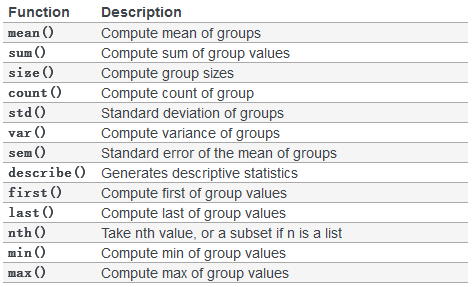

In [5]:
df.groupby(['A']).sum()
# 可以直接把'sum'字符串作为agg的参数
df.groupby(['A']).agg('sum')

,C,D
A,,
bar,-0.380941,0.052104
foo,-0.240294,-2.322023


,C,D
A,,
bar,-0.380941,0.052104
foo,-0.240294,-2.322023


### 一次进行多个聚合计算

`agg`的参数还可以是包含多个聚合函数或者代表聚合函数的字符串的列表，此时会对每一列同时进行多个聚合计算，结果的列的索引将会是一个包含列名和函数名的层级索引：

In [6]:
df.groupby('A').agg(['sum', np.mean])

C                   D          
          sum      mean       sum      mean
A                                          
bar -0.380941 -0.126980  0.052104  0.017368
foo -0.240294 -0.048059 -2.322023 -0.464405

`pandas`不允许传入两个一样的函数，此时会抛出`SpecificationError`错误：

In [7]:
try:
    df.groupby(['A']).agg(['sum', 'sum'])
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

SpecificationError: Function names must be unique if there is no new column names assigned


如果你传入的是`lambda`函数，列名会是<lambda_数字>的格式，此时你可以通过调用`rename()`方法更改为你想要的名称：

In [8]:
df.groupby(['A']).agg(
    [lambda x: x.max() - x.min(), lambda x: x.median() - x.mean()])

df.groupby(['A']).agg(
    [lambda x: x.max() - x.min(),
     lambda x: x.median() - x.mean()]).rename(columns={
         '<lambda_0>': 'max-min',
         '<lambda_1>': 'median-mean'
     })

C                     D           
    <lambda_0> <lambda_1> <lambda_0> <lambda_1>
A                                              
bar   1.275436   0.324457   0.649116   0.033274
foo   3.762556  -0.376088   2.231759   0.129770

C                     D            
      max-min median-mean   max-min median-mean
A                                              
bar  1.275436    0.324457  0.649116    0.033274
foo  3.762556   -0.376088  2.231759    0.129770

### 为不同的列指定不同的聚合计算

如果想对不同的列指定不同的聚合计算，可以传入一个字典，键是列的名称，值是聚合函数。当然，值也可以是一个列表，包含多个聚合函数：

In [9]:
df.groupby('A').agg({'C': [np.sum, 'mean'], 'D': 'mean'})

C                   D
          sum      mean      mean
A                                
bar -0.380941 -0.126980  0.017368
foo -0.240294 -0.048059 -0.464405

### 命名聚合（Named aggregation）

0.25版本以后，`pandas`还提供了一种叫`Named aggregation`（命名聚合）的语法，它其实也是对不同的列指定不同的聚合计算，只不过它还结合了`rename`的作用，直接指定了返回的列的名称：
- 传入`agg`的关键字参数会称为输出列的名称
- 值是一个元组，其中第一个参数是列名，第二个参数是对应的聚合函数，可以是可调用对象或者是字符串

In [10]:
df.groupby(['A']).agg(
    c_sum=pd.NamedAgg(column='C', aggfunc='sum'),
    c_mean=pd.NamedAgg(column='C', aggfunc='mean'))

,c_sum,c_mean
A,,
bar,-0.380941,-0.126980
foo,-0.240294,-0.048059


上面的`pd.NamedAgg`其实就是一个命名元组，你也可以使用普通的元组：

In [11]:
df.groupby(['A']).agg(c_sum=('C', 'sum'), c_mean=('C', 'mean'))

,c_sum,c_mean
A,,
bar,-0.380941,-0.126980
foo,-0.240294,-0.048059


如果你希望的输出的列名不是一个有效的关键字参数（比如'C sum'，关键字参数不允许有空格），那么可以构造一个字典然后使用`**`解包：

In [12]:
df.groupby(['A']).agg(**{'C sum': ('C', 'sum'), 'C mean': ('C', 'mean')})

,C sum,C mean
A,,
bar,-0.380941,-0.126980
foo,-0.240294,-0.048059


上面都是对`dataframe`对象进行聚合，所以需要选择要进行聚合计算的列，如果是对一个`Series`聚合，那就更简单了，直接传入要作为列名称的关键字和对应的聚合函数就好了：

In [13]:
df['C'].groupby(df['A']).agg(c_sum='sum', c_mean='mean')

,c_sum,c_mean
A,,
bar,-0.380941,-0.126980
foo,-0.240294,-0.048059


In [14]:
# 此时使用字典的方式，值也不用是元组了，直接就可以是聚合函数
df['C'].groupby(df['A']).agg(**{'max-min': lambda x: x.max() - x.min()})

,max-min
A,
bar,1.275436
foo,3.762556


### 使用`apply`进行聚合

对分组数据的某些操作可能不适合使用`agg`或`transform`，比如：只是希望`GroupBy`来推断如何组合结果。此时，可以使用`apply`函数，它不但可以在许多标准用例中代替聚合和转换，而且还可以处理一些特殊的用例：

In [29]:
grouped = df.groupby('A')
grouped.apply(lambda x: x.describe())
# 可以直接调用describe方法，查看格式上有什么不同
# grouped.describe()

C         D
A                            
bar count  3.000000  3.000000
    mean  -0.126980  0.017368
    std    0.696878  0.325835
    min   -0.926927 -0.323827
    25%   -0.364725 -0.136593
    50%    0.197476  0.050642
    75%    0.272993  0.187965
    max    0.348509  0.325289
foo count  5.000000  5.000000
    mean  -0.048059 -0.464405
    std    1.422259  0.859157
    min   -1.620904 -1.565526
    25%   -0.739488 -1.008948
    50%   -0.424147 -0.334635
    75%    0.402593 -0.079147
    max    2.141652  0.666233

`apply`返回的维度可以是任意的，注意，这里不能使用`agg`方法，因为`agg`的函数必须是聚合函数，最后只能返回一个标量：

In [16]:
def f(group):
    return DataFrame({
        'origin_C': group['C'],
        'demeaned_C': group['C'] - group['C'].mean()
    })


grouped.apply(f)
try:
    grouped.agg(
        origin_C=('C', lambda x: x), demeaned_C=('C', lambda x: x - x.mean()))
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

,origin_C,demeaned_C
0,2.141652,2.189711
1,0.197476,0.324457
2,-1.620904,-1.572845
3,0.348509,0.475489
4,0.402593,0.450652
5,-0.926927,-0.799946
6,-0.739488,-0.691429
7,-0.424147,-0.376088


ValueError: Must produce aggregated value


关于`apply`，有个要注意的地方就是，如果`apply`返回结果的索引值不变，则`groupby`的字段不会成为索引，否则，会以`groupby`的字段作为返回结果的索引，如下：

In [49]:
def absgroup(g):
    g["C"] = g["C"].abs()
    g["D"] = g["D"].abs()
    return g

df.groupby("A").apply(absgroup)

,A,B,C,D
0,foo,one,2.141652,0.666233
1,bar,one,0.197476,0.323827
2,foo,two,1.620904,0.334635
3,bar,three,0.348509,0.050642
4,foo,two,0.402593,1.565526
5,bar,two,0.926927,0.325289
6,foo,one,0.739488,1.008948
7,foo,three,0.424147,0.079147


### `agg`和`apply`的本质区别

`apply`得到的结果有时候出乎意料，和`agg`得到的结果不一样：

In [17]:
try:
    df.groupby('A').apply('sum')
except Exception as e:
    print(f"{e}")

'str' object is not callable


In [18]:
df.groupby('A').agg('sum')
df.groupby('A').apply(np.sum)

,C,D
A,,
bar,-0.380941,0.052104
foo,-0.240294,-2.322023


,A,B,C,D
A,,,,
bar,barbarbar,onethreetwo,-0.380941,0.052104
foo,foofoofoofoofoo,onetwotwoonethree,-0.240294,-2.322023


为什么会出现这样的情况，我们来深入了解一下，来看看`GroupBy`对象调用`agg`或者`apply`时，到底发生了什么。我们先定义一个伪造的聚合函数，看每一次传入这个函数的到底是什么，这个函数返回一个标量，代表这个聚合函数调用的次数：

In [24]:
def call_nums():
    start = 0
    def func(s):
        nonlocal start
        start = start + 1
        print(s)
        print("-"*35)
        return start
    return func

In [25]:
df.groupby('A').agg(call_nums())

1      one
3    three
5      two
Name: B, dtype: object
-----------------------------------
0      one
2      two
4      two
6      one
7    three
Name: B, dtype: object
-----------------------------------
1    0.197476
3    0.348509
5   -0.926927
Name: C, dtype: float64
-----------------------------------
0    2.141652
2   -1.620904
4    0.402593
6   -0.739488
7   -0.424147
Name: C, dtype: float64
-----------------------------------
1   -0.323827
3    0.050642
5    0.325289
Name: D, dtype: float64
-----------------------------------
0    0.666233
2   -0.334635
4   -1.565526
6   -1.008948
7   -0.079147
Name: D, dtype: float64
-----------------------------------


,B,C,D
A,,,
bar,1,3.0,5.0
foo,2,4.0,6.0


可见，函数一共调用了6次，依次传入每个组的每一列，聚合函数是对组的每一列进行计算，最后再拼接，因此返回的结果保留了列数。'A'列由于是标签列，不会传入，前面也提到过，`pandas`针对`sum`进行了优化，如果将`sum`传入`agg`，不会对字符串进行聚合。再来看`apply`：

In [147]:
df.groupby('A').apply(call_nums())

     A      B         C         D
1  bar    one  0.707970  1.009140
3  bar  three  1.335269  0.755735
5  bar    two -0.867476 -0.044746
-----------------------------------
     A      B         C         D
0  foo    one  1.247962 -0.870213
2  foo    two  1.239203 -1.138821
4  foo    two -0.253874 -0.558603
6  foo    one -0.953907 -0.291930
7  foo  three -0.491869 -0.896568
-----------------------------------


A
bar    1
foo    2
dtype: int64

In [150]:
for name, value in df.groupby('A'):
    print(f"{name}:")
    print(value)
    print("-"*35)

bar:
     A      B         C         D
1  bar    one  0.707970  1.009140
3  bar  three  1.335269  0.755735
5  bar    two -0.867476 -0.044746
-----------------------------------
foo:
     A      B         C         D
0  foo    one  1.247962 -0.870213
2  foo    two  1.239203 -1.138821
4  foo    two -0.253874 -0.558603
6  foo    one -0.953907 -0.291930
7  foo  three -0.491869 -0.896568
-----------------------------------


可见，一共只调用了2次，对于`apply`，只是简单的对`GroupBy`对象进行轮询，将每一组的值传给`apply`，这个例子组的值是`dataframe`对象，因此`apply`是直接对整个`dataframe`对象进行聚合计算，最后再将结果拼接起来。

知道原理，就明白为什么会出现意料外的结果了，最后总结一下两者的差异：
- `apply`不能传入聚合函数的字符串别名。
- `GroupBy`对象调用两者时，传的内容不同，`agg`是依次传入组的每一列，`apply`是一次性传入一个组。
- 两者对于某些聚合计算有差别，如：`sum`的话，`agg`不会对字符串类型进行聚合，而`apply`会。

### 优化了的聚合函数

到目前0.25版本，`Pandas`对`sum`，`mean`，`std`，`sem`这四个常用的聚合函数进行了底层的优化（`Cython`版本），另外，直接在`GroupBy`对象上调用方法都会比调用`agg`要快一点：

In [50]:
gd = df.groupby(['A', 'B'])
%timeit gd.describe()
%timeit gd.agg('describe')

26.6 ms ± 421 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.4 ms ± 246 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 转换（Transformation） 

### 理解`transform`转换

`transform`方法返回与正在分组的对象索引相同(大小相同)的对象。转换函数必须：
- 返回与组块大小相同或可广播到组块大小的结果（广播是`numpy`的概念，可以查看《numpy私房手册》）。
- 不在组块上执行就地操作。组块应该被视为不可变的，对组块的更改可能会产生意想不到的结果。例如，当使用`fillna`时，inplace必须为`False`(分组)。例如：`(grouped.transform(lambda x: x.fillna(inplace=False)))`。

In [159]:
df1 = df.loc[:, ['A', 'C', 'D']]
df1 = df1.sort_values('A')[:5]
df1
df1.groupby('A').transform('mean')

,A,C,D
1,bar,0.707970,1.009140
3,bar,1.335269,0.755735
5,bar,-0.867476,-0.044746
0,foo,1.247962,-0.870213
2,foo,1.239203,-1.138821


,C,D
1,0.391921,0.573376
3,0.391921,0.573376
5,0.391921,0.573376
0,1.243583,-1.004517
2,1.243583,-1.004517


### `transform`常见用法

#### 快速标准化

`transform`的一个常见用法是快速实现标准化：

In [161]:
index = pd.date_range('10/1/1999', periods=1100)
ts = pd.Series(np.random.normal(0.5, 2, 1100), index)
ts = ts.rolling(window=100, min_periods=100).mean().dropna()
ts.head()

2000-01-08    0.455640
2000-01-09    0.459219
2000-01-10    0.439759
2000-01-11    0.450737
2000-01-12    0.464157
Freq: D, dtype: float64

下面这段代码要注意的是：`groupby`参数中的`x`和`transform`参数中的`x`是不同的，前者是`ts`的标签，后者是分组以后的每一个分组块。`transform`返回的是与分组块形状相同的一个`Series`，得到的是标准化（减去均值除以方差）以后的`Series`：

In [162]:
transformed = (
    ts.groupby(lambda x: x.year).transform(lambda x: (x - x.mean()) / x.std()))
transformed.head()

2000-01-08   -0.201216
2000-01-09   -0.154685
2000-01-10   -0.407638
2000-01-11   -0.264936
2000-01-12   -0.090496
Freq: D, dtype: float64

很容易检查`transformed`是否已经标准化（均值为0，方差为1）：

In [165]:
transformed.groupby(lambda x:x.year).mean() # 实际结果为一个非常小，近似为0的数
transformed.groupby(lambda x:x.year).std()

2000    1.773574e-16
2001   -1.040264e-16
2002    2.244494e-17
dtype: float64

2000    1.0
2001    1.0
2002    1.0
dtype: float64

#### 填补缺失值

`transform`还有一个常见用法就是填补空值，如下：

In [189]:
df = pd.DataFrame({
    'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
    'C': np.random.randn(8),
    'D': np.random.randn(8)
})

df.iloc[2, 1] = np.nan
df.iloc[3, 2] = np.nan
df.iloc[5, 2] = np.nan
df.iloc[6, 1] = np.nan

df
df.groupby('A').mean()
# 可见，NaN被分组的均值填充
df.groupby('A').transform(lambda x:x.fillna(x.mean()))

,A,C,D
0,foo,1.096912,1.142890
1,bar,0.449171,2.445979
2,foo,NaN,0.220296
3,bar,-1.758654,NaN
4,foo,-0.728914,0.977942
5,bar,0.286941,NaN
6,foo,NaN,0.916691
7,foo,0.148620,0.944379


,C,D
A,,
bar,-0.340847,2.445979
foo,0.172206,0.840440


,C,D
0,1.096912,1.142890
1,0.449171,2.445979
2,0.172206,0.220296
3,-1.758654,2.445979
4,-0.728914,0.977942
5,0.286941,2.445979
6,0.172206,0.916691
7,0.148620,0.944379


### 窗口和重采样方法的新语法

0.18.1版本以后，也可以对`GroupBy`对象直接调用窗口函数`rolling`，`expanding`和重采样方法`resample`了，这几个方法在时间序列的分析中用的比较多，具体用法请参考《pandas私房手册-时间和日期》，有几点需要注意：
- 如果以某列为`groupby`的依据进行聚合，普通的聚合函数不会在结果中保留该列，但是`rolling`，`expanding`等窗口函数会保留。

In [13]:
df_re = pd.DataFrame({'A': [1] * 4 + [5] * 4, 'B': np.arange(8)})
df_re.groupby('A').rolling(2).mean()
# 以A列进行聚合，rolling的结果仍然保留A列，因此如果只想获取B列的结果，需要像下面这样
# df_re.groupby('A').rolling(2).B.mean()

A    B
A            
1 0  NaN  NaN
  1  1.0  0.5
  2  1.0  1.5
  3  1.0  2.5
5 4  NaN  NaN
  5  5.0  4.5
  6  5.0  5.5
  7  5.0  6.5

`GroupBy`对象的`resample`方法和`rolling`等窗口函数一样，针对组进行重采样，这里仅举个例子：

In [15]:
df_re = pd.DataFrame({
    'date':
    pd.date_range(start='2016-01-01', periods=4, freq='W'),
    'group': [1, 1, 2, 2],
    'val': [5, 6, 7, 8]
}).set_index('date')
df_re

,group,val
date,,
2016-01-03,1,5
2016-01-10,1,6
2016-01-17,2,7
2016-01-24,2,8


In [16]:
df_re.groupby('group').resample('1D').ffill()

group  val
group date                  
1     2016-01-03      1    5
      2016-01-04      1    5
      2016-01-05      1    5
      2016-01-06      1    5
      2016-01-07      1    5
      2016-01-08      1    5
      2016-01-09      1    5
      2016-01-10      1    6
2     2016-01-17      2    7
      2016-01-18      2    7
      2016-01-19      2    7
      2016-01-20      2    7
      2016-01-21      2    7
      2016-01-22      2    7
      2016-01-23      2    7
      2016-01-24      2    8

## 过滤（Filtration）

过滤很好理解，`filter`方法返回原始对象的子集，`filter`方法的第一个参数必须是一个函数，应用于整个组时，返回`True`或者`False`，假设我们只想取组的和大于2的所有元素：

In [17]:
sf = pd.Series([1, 1, 2, 3, 3, 3])
sf
sf.groupby(sf).filter(lambda x: x.sum() > 2)

0    1
1    1
2    2
3    3
4    3
5    3
dtype: int64

3    3
4    3
5    3
dtype: int64

`filter`的一个有用的用法是过滤掉属于某些组的元素，当然在下面这个例子，你可以使用`loc`或者`iloc`轻松实现，但是`filter`还有个`dropna`的参数，可以设置是否保留不满足条件的组，如果选择保留，用`NaN`来进行填充：

In [24]:
dff = pd.DataFrame({'A': np.arange(8), 'B': list('aabbbbcc')})
dff.groupby('B').filter(lambda x: len(x) > 2)
dff.groupby('B').filter(lambda x: len(x) > 2, dropna=False)

,A,B
2,2,b
3,3,b
4,4,b
5,5,b


,A,B
0,NaN,NaN
1,NaN,NaN
2,2.0,b
3,3.0,b
4,4.0,b
5,5.0,b
6,NaN,NaN
7,NaN,NaN


## 其它的有用的特性

### 哪个效率更高

如果我们只需要对`groupby`结果的某一列进行聚合计算，假设我们对`A`列`groupby`，对`B`列进行聚合计算，那么`df.groupby['A'].C.agg(func)`的效率比`df.groupby['A'].agg(func).c`效率要高：

In [93]:
df = pd.DataFrame({
    'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
    'B': ['one', 'one', 'two', 'three', 'two', 'two', 'one', 'three'],
    'C': np.random.randn(8),
    'D': np.random.randn(8)
})

In [94]:
%timeit df.groupby('A').agg('std')['C']

3.24 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [96]:
%timeit df.groupby('A')['C'].agg('std')

1.56 ms ± 84 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 排除“麻烦数据”

前面提到过，对于`agg`来说，如果传递的聚合函数不能应用于某些列，那么麻烦的列将会被(无声地)删除。任何对象列都被视为讨厌的列，它们被排除在`groupby`中的聚合函数之外。如果希望在聚合中包含小数列或对象列以及其他非讨厌的数据类型，则必须显式地这样做:

In [97]:
from decimal import Decimal

df_dec = pd.DataFrame({
    'id': [1, 2, 1, 2],
    'int_column': [1, 2, 3, 4],
    'dec_column':
    [Decimal('0.50'),
     Decimal('0.15'),
     Decimal('0.25'),
     Decimal('0.40')]
})
# 单独一列显示求和，没有问题
df_dec.groupby(['id'])[['dec_column']].sum()
# 但不能与标准数据类型组合，否则将被排除
df_dec.groupby(['id'])[['int_column', 'dec_column']].sum()
# 使用.agg函数聚合标准的和“讨厌的”数据类型
df_dec.groupby(['id']).agg({'int_column': 'sum', 'dec_column': 'sum'})

,dec_column
id,
1,0.75
2,0.55


,int_column
id,
1,4
2,6


,int_column,dec_column
id,,
1,4,0.75
2,6,0.55


### 处理观察不到的`Categorical`类型的值

`groupby`有一个`observed`参数，它控制是返回所有可能的`gropuer`的笛卡尔积`(observed=False)`，还是只返回已观察到的`grouper`值的笛卡尔积`(observed=True)`。

In [98]:
pd.Series([1, 1, 1]).groupby(
    pd.Categorical(['a', 'a', 'a'], categories=['a', 'b']),
    observed=False).count()

pd.Series([1, 1, 1]).groupby(
    pd.Categorical(['a', 'a', 'a'], categories=['a', 'b']),
    observed=True).count()

a    3
b    0
dtype: int64

a    3
dtype: int64

另外，如果使用`Categorical`作为`groupby`的依据，那么将保留`categories`分类的顺序:

In [100]:
pd.Series([1, 1, 1]).groupby(
    pd.Categorical(['a', 'a', 'a'], categories=['b', 'a']),
    observed=False).count()

b    0
a    3
dtype: int64

### 使用`grouper`进行分组

对于日期时间数据，经常需要有规律的分组，比如每个月，每个季度，或者每年，可以使用`pd.grouper`来实现这个需求：

In [102]:
import datetime
df = pd.DataFrame({
    'Branch':
    'A A A A A A A B'.split(),
    'Buyer':
    'Carl Mark Carl Carl Joe Joe Joe Carl'.split(),
    'Quantity': [1, 3, 5, 1, 8, 1, 9, 3],
    'Date': [
        datetime.datetime(2013, 1, 1, 13, 0),
        datetime.datetime(2013, 1, 1, 13, 5),
        datetime.datetime(2013, 10, 1, 20, 0),
        datetime.datetime(2013, 10, 2, 10, 0),
        datetime.datetime(2013, 10, 1, 20, 0),
        datetime.datetime(2013, 10, 2, 10, 0),
        datetime.datetime(2013, 12, 2, 12, 0),
        datetime.datetime(2013, 12, 2, 14, 0)
    ]
})
df

,Branch,Buyer,Quantity,Date
0,A,Carl,1,2013-01-01 13:00:00
1,A,Mark,3,2013-01-01 13:05:00
2,A,Carl,5,2013-10-01 20:00:00
3,A,Carl,1,2013-10-02 10:00:00
4,A,Joe,8,2013-10-01 20:00:00
5,A,Joe,1,2013-10-02 10:00:00
6,A,Joe,9,2013-12-02 12:00:00
7,B,Carl,3,2013-12-02 14:00:00


现在想要统计每个月，不同买家购买的数量：

In [105]:
df.groupby([pd.Grouper(freq='1M', key='Date'), 'Buyer']).sum()

Quantity
Date       Buyer          
2013-01-31 Carl          1
           Mark          3
2013-10-31 Carl          6
           Joe           9
2013-12-31 Carl          3
           Joe           9

`pd.Grouper`使用`key`指定列，`level`指定索引，这样就算索引的名称和列的名称是一样的，也不会混淆。

### 画图

`Groupby`对象还可以使用一些绘图方法。例如，假设我们怀疑`DataFrame`中的一些特性可能因组而异，在下面的例子中，组为`B`的第1列中的值平均要高3：

A         AxesSubplot(0.1,0.15;0.363636x0.75)
B    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

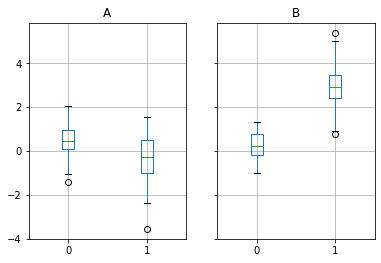

In [143]:
np.random.seed(1234)
df = pd.DataFrame(np.random.randn(50, 2))
df['g'] = np.random.choice(['A', 'B'], size=50)
df.loc[df['g'] == 'B', 1] += 3
df.groupby('g').boxplot()

### 使用管道函数

0.21.0之后，可以使用管道方法`pipe`将接受`GroupBy`对象的函数链接在一起，从而实现更清晰、更可读的语法，特别是需要重用`GroupBy`对象时，比如下面的例子，现在想要获得不同商店，不同产品的单个利润（Revenue / Quantity）：

In [144]:
n = 1000
df = pd.DataFrame({
    'Store': np.random.choice(['Store_1', 'Store_2'], n),
    'Product': np.random.choice(['Product_1', 'Product_2'], n),
    'Revenue': (np.random.random(n) * 50 + 10).round(2),
    'Quantity': np.random.randint(1, 10, size=n)
})
df.head()

,Store,Product,Revenue,Quantity
0,Store_2,Product_1,26.12,1
1,Store_2,Product_1,28.86,1
2,Store_2,Product_1,35.11,9
3,Store_1,Product_1,32.50,1
4,Store_1,Product_2,33.37,1


如果使用普通的`agg`方法，必须要分为两部，像这样：

In [157]:
df_tmp = df.groupby(['Store', 'Product']).sum()
(df_tmp['Revenue'] / df_tmp['Quantity']).unstack().round(2)

Product,Product_1,Product_2
Store,,
Store_1,6.82,7.05
Store_2,6.30,6.64


如果使用`pipe`的话，就不需要中间变量，其中`g`为整个返回的整个`GroupBy`对象，`g.Revenue.sum()`相当于`df.groupby(['Store', 'Product'])['Revenue'].sum()`或者：`df['Revenue'].groupby(['Store', 'Product']).sum()`

In [159]:
df.groupby([
    'Store', 'Product'
]).pipe(lambda g: g.Revenue.sum() / g.Quantity.sum()).unstack().round(2)

Product,Product_1,Product_2
Store,,
Store_1,6.82,7.05
Store_2,6.30,6.64


当然你也可以利用`apply`方法，`pipe`和`apply`的区别在于：每次传给`pipe`函数的是整个`GroupBy`对象，只调用了一次，而传给`apply`函数的是分组块，有几个分组就调用了几次。

In [154]:
df.groupby([
    'Store', 'Product'
]).apply(lambda g: g['Revenue'].sum() / g['Quantity'].sum()).unstack().round(2)

Product,Product_1,Product_2
Store,,
Store_1,6.82,7.05
Store_2,6.30,6.64


## 一些例子

### 根据分组的结果再进行分组 

根据`dataframe`的和对列进行重新分组，并对聚合的列求和，这个比较烧脑，也是看对`groupby`的轴方向是否理解深刻：

In [161]:
df = pd.DataFrame({
    'a': [1, 0, 0],
    'b': [0, 1, 0],
    'c': [1, 0, 0],
    'd': [2, 3, 4]
})
df

,a,b,c,d
0,1,0,1,2
1,0,1,0,3
2,0,0,0,4


In [162]:
df.groupby(df.sum(), axis=1).sum()

,1,9
0,2,2
1,1,3
2,0,4


### 巧妙处理列或者索引进行重新采样

我们可以根据需求通过现有的列或者索引经过处理生成新的序列，作为`groupby`的依据：

In [164]:
df = pd.DataFrame(np.random.randn(10, 2))
df.head()
df.groupby(df.index // 5).std()

,0,1
0,-1.157426,-0.096491
1,0.999344,-1.482012
2,0.189291,0.926828
3,-0.029095,1.776600
4,-1.334294,2.085399


,0,1
0,0.974731,1.458479
1,1.003779,0.553559


### 返回一个`Series`来传播名称

对`DataFrame`列进行分组，计算一组指标并返回一个指定的系列。系列名称用作列索引的名称。这对于重新构造操作(比如将列索引名用作插入列的名称)特别有用：

In [35]:
df = pd.DataFrame({
    'a': [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2],
    'b': [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
    'c': [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
    'd': [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]
})

In [181]:
def compute_metrics(x):
    result = {'b_sum': x['b'].sum(), 'c_mean': x['c'].mean()}
    return pd.Series(result, name='metrics')


df.groupby('a').apply(compute_metrics)

metrics,b_sum,c_mean
a,,
0,2.0,0.5
1,2.0,0.5
2,2.0,0.5


也可以使用使用`pipe`管道函数，如下：

In [37]:
DataFrame(Series([1,2,3], name='a'))

,a
0,1
1,2
2,3


In [39]:
def process_g(g):
    return DataFrame({
        'b_sum': g['b'].sum(),
        'c_sum': g['c'].mean()
    }).rename_axis(
        'metrics', axis=1)


df.groupby('a').pipe(process_g)

metrics,b_sum,c_sum
a,,
0,2,0.5
1,2,0.5
2,2,0.5
